In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("diabetic_data.csv")

In [2]:
mask = (
    (df[["diag_1", "diag_2", "diag_3"]] == "?").any(axis=1)
    | (df["race"] == "?")
    | (df["discharge_disposition_id"] == 11)
    | (df["gender"] == "Unknown/Invalid")
)
df = df[~mask]

df["admission_type_id"] = df["admission_type_id"].replace({2:1, 7:1, 6:5, 8:5})

df["discharge_disposition_id"] = df["discharge_disposition_id"].replace({
    6:1, 8:1, 9:1, 13:1,
    3:2, 4:2, 5:2, 14:2, 22:2, 23:2, 24:2,
    12:10, 15:10, 16:10, 17:10,
    25:18, 26:18
})

df["admission_source_id"] = df["admission_source_id"].replace({
    2:1, 3:1,
    5:4, 6:4, 10:4, 22:4, 25:4,
    15:9, 17:9, 20:9, 21:9,
    13:11, 14:11
})

df["change"] = df["change"].replace({"Ch":1, "No":0})
df["gender"] = df["gender"].replace({"Male":1, "Female":0})
df["diabetesMed"] = df["diabetesMed"].replace({"Yes":1, "No":0})
df["A1Cresult"] = df["A1Cresult"].replace({">7":1, ">8":1, "Norm":0, "None":-99})
df["max_glu_serum"] = df["max_glu_serum"].replace({">200":1, ">300":1, "Norm":0, "None":-99})
df["readmitted"] = df["readmitted"].replace({">30":0, "<30":1, "NO":0})

age_mapping = {f"[{i*10}-{(i+1)*10})": i+1 for i in range(10)}
df["age"] = df["age"].replace(age_mapping)

df = df.drop_duplicates(subset=["patient_nbr"], keep="first")
df = df.drop(["weight", "payer_code", "medical_specialty"], axis=1)



In [3]:
med_columns = [
    "metformin","repaglinide","nateglinide","chlorpropamide","glimepiride",
    "acetohexamide","glipizide","glyburide","tolbutamide","pioglitazone",
    "rosiglitazone","acarbose","miglitol","troglitazone","tolazamide",
    "insulin","glyburide-metformin","glipizide-metformin",
    "glimepiride-pioglitazone","metformin-rosiglitazone",
    "metformin-pioglitazone","change","diabetesMed"
]

categorical_cols = [
    "gender","admission_type_id","discharge_disposition_id",
    "admission_source_id","max_glu_serum","A1Cresult","race"
] + med_columns

numeric_cols = [
    "age","time_in_hospital","num_procedures","num_medications",
    "number_outpatient","number_emergency",
    "number_inpatient","number_diagnoses"
]

df[numeric_cols] = df[numeric_cols].astype(float)
df[numeric_cols] = (df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()

df = df[(np.abs(sp.stats.zscore(df[numeric_cols])) < 3).all(axis=1)]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

numeric_features = [
    "age",
    "time_in_hospital",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses",
]

dummy_features = [
    col for col in df_encoded.columns
    if col not in numeric_features + ["readmitted"]
    and df_encoded[col].dtype != "object"
]

X = df_encoded[numeric_features + dummy_features]
y = df_encoded["readmitted"]


In [4]:
X_majority = X[y == 0]
X_minority = X[y == 1]

X_minority_upsampled = resample(
    X_minority, replace=True, n_samples=len(X_majority), random_state=20
)

X_balanced = pd.concat([X_majority, X_minority_upsampled])
y_balanced = pd.Series([0]*len(X_majority) + [1]*len(X_minority_upsampled))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=0
)

In [8]:
rf = RandomForestClassifier(
    n_estimators=10, max_depth=25, min_samples_split=10, random_state=0
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("\n--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))


--- Random Forest ---
Accuracy: 0.9590735623108304
Precision: 0.9415204678362573
Recall: 0.979744414500565


In [9]:
dnn = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

dnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

dnn.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=0
)

dnn_pred = (dnn.predict(X_test) > 0.5).astype(int).ravel()

print("\n--- Deep Neural Network ---")
print("Accuracy:", accuracy_score(y_test, dnn_pred))
print("Precision:", precision_score(y_test, dnn_pred))
print("Recall:", recall_score(y_test, dnn_pred))


713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step

--- Deep Neural Network ---
Accuracy: 0.49541606351712947
Precision: 0.0
Recall: 0.0


In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    fit_intercept=True,
    max_iter=1000
)

lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print("\n--- Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, lr_pred))
print("Precision:", precision_score(y_test, lr_pred))
print("Recall:", recall_score(y_test, lr_pred))



--- Logistic Regression ---
Accuracy: 0.6070096942580164
Precision: 0.6251722101948435
Recall: 0.5522907067721464


In [11]:
models_preds = {
    "Logistic Regression": (lr, lr.predict(X_train), lr.predict(X_test)),
    "Random Forest": (rf, rf.predict(X_train), rf.predict(X_test)),
    "Deep Neural Network": (
        dnn,
        (dnn.predict(X_train) > 0.5).astype(int).ravel(),
        (dnn.predict(X_test) > 0.5).astype(int).ravel(),
    ),
}

metrics = {"accuracy": accuracy_score, "precision": precision_score, "recall": recall_score}

results = {}

for model_name, (_, y_train_pred, y_test_pred) in models_preds.items():
    results[model_name] = {
        "train": {m: metrics[m](y_train, y_train_pred) for m in metrics},
        "test": {m: metrics[m](y_test, y_test_pred) for m in metrics},
    }


2850/2850 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step


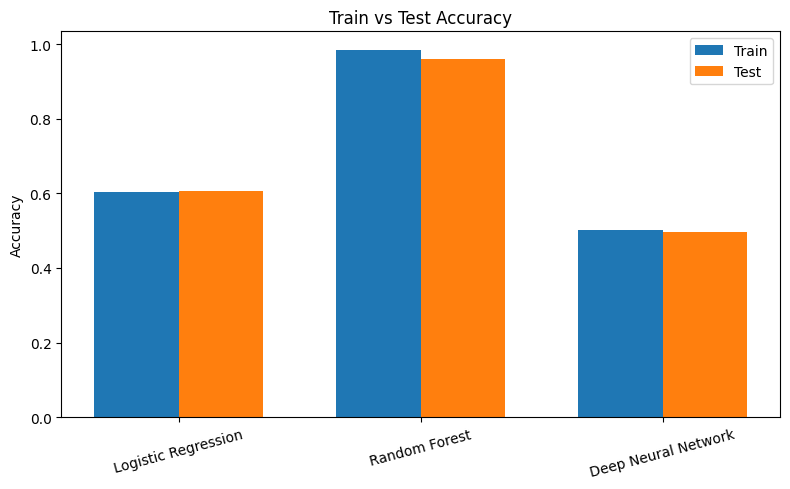

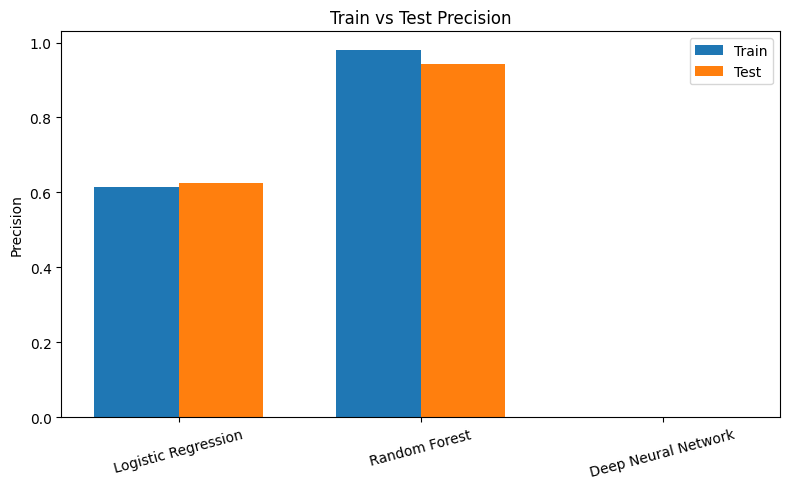

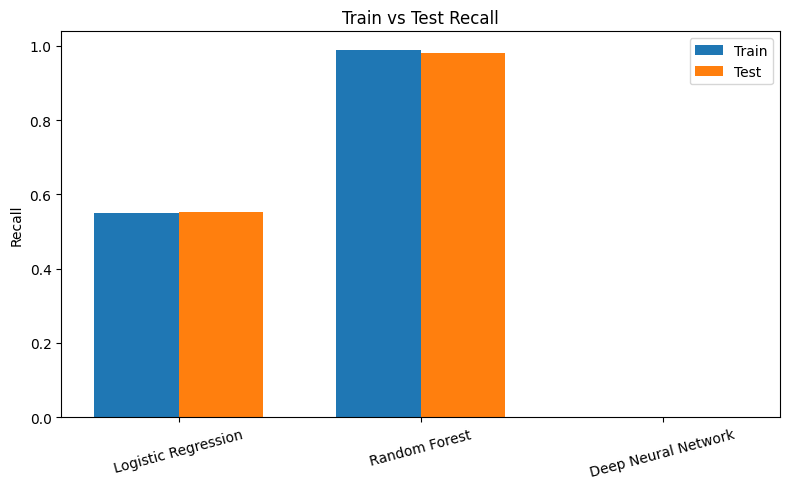

In [12]:
import numpy as np
import matplotlib.pyplot as plt

for metric in ["accuracy", "precision", "recall"]:
    plt.figure(figsize=(8, 5))
    x = np.arange(len(results))
    width = 0.35

    train_scores = [results[m]["train"][metric] for m in results]
    test_scores = [results[m]["test"][metric] for m in results]

    plt.bar(x - width/2, train_scores, width, label="Train")
    plt.bar(x + width/2, test_scores, width, label="Test")

    plt.xticks(x, results.keys(), rotation=15)
    plt.ylabel(metric.capitalize())
    plt.title(f"Train vs Test {metric.capitalize()}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [13]:
train_table = pd.DataFrame({
    "Model": results.keys(),
    "Accuracy": [results[m]["train"]["accuracy"] for m in results],
    "Precision": [results[m]["train"]["precision"] for m in results],
    "Recall": [results[m]["train"]["recall"] for m in results],
})

train_table = train_table.set_index("Model")
print("\nTrain Performance")
display(train_table)



Train Performance


,Accuracy,Precision,Recall
Model,,,
Logistic Regression,0.604047,0.615620,0.549156
Random Forest,0.985327,0.980937,0.989821
Deep Neural Network,0.501146,0.000000,0.000000


In [14]:
test_table = pd.DataFrame({
    "Model": results.keys(),
    "Accuracy": [results[m]["test"]["accuracy"] for m in results],
    "Precision": [results[m]["test"]["precision"] for m in results],
    "Recall": [results[m]["test"]["recall"] for m in results],
})

test_table = test_table.set_index("Model")
print("\nTest Performance")
display(test_table)



Test Performance


,Accuracy,Precision,Recall
Model,,,
Logistic Regression,0.607010,0.625172,0.552291
Random Forest,0.959074,0.941520,0.979744
Deep Neural Network,0.495416,0.000000,0.000000


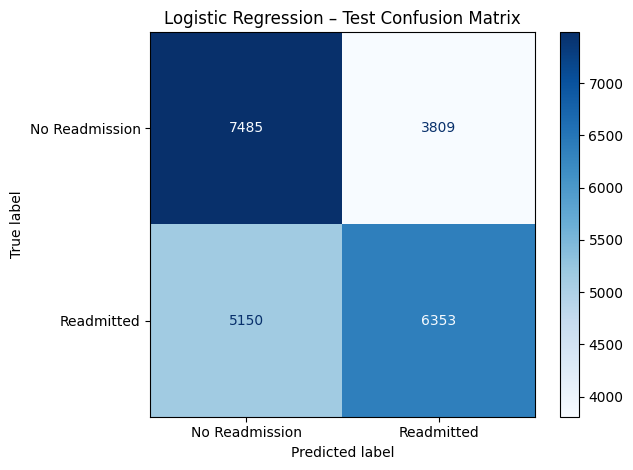

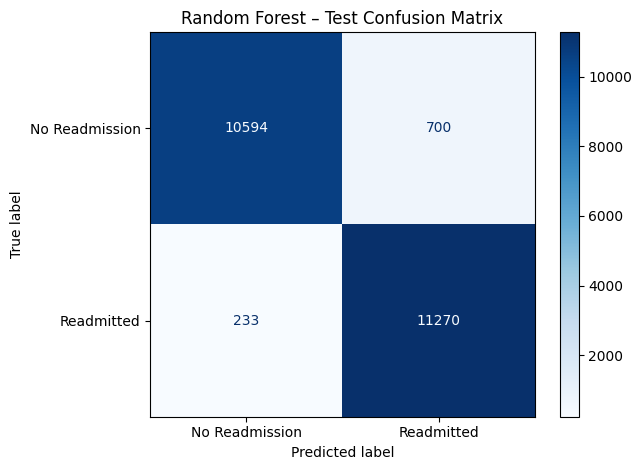

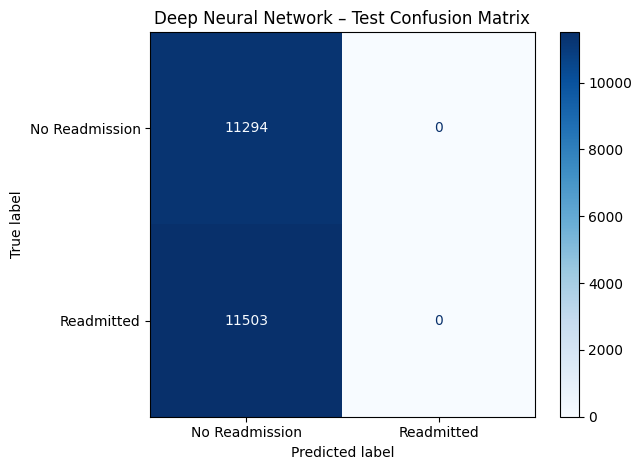

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_preds = {
    "Logistic Regression": lr_pred,
    "Random Forest": rf_pred,
    "Deep Neural Network": dnn_pred,
}

for model_name, y_pred in test_preds.items():
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["No Readmission", "Readmitted"]
    )

    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{model_name} – Test Confusion Matrix")
    plt.tight_layout()
    plt.show()
